In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import skimage.exposure
import os

In [ ]:
!unzip "/content/drive/MyDrive/mammography_images.zip"

In [ ]:
train=pd.read_csv("/content/mammography_images/Training_set.csv")
test=pd.read_csv("/content/mammography_images/Testing_set.csv")
sub=pd.read_csv("/content/mammography_images/sample_submission.csv")

In [ ]:
train.head()

,filename,label
0,Image_1.jpg,Density3Benign
1,Image_2.jpg,Density1Benign
2,Image_3.jpg,Density1Malignant
3,Image_4.jpg,Density1Benign
4,Image_5.jpg,Density1Malignant


In [ ]:
print("len of training set", len(train))
print("len of testing set", len(test))

len of training set 5724
len of testing set 1908


In [ ]:
(train["label"].value_counts())

Density2Malignant    1728
Density1Malignant    1620
Density3Benign        702
Density1Benign        648
Density3Malignant     432
Density4Benign        324
Density2Benign        216
Density4Malignant      54
Name: label, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

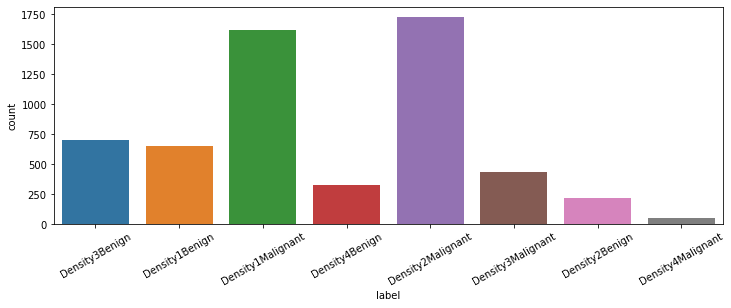

In [ ]:
plt.figure(figsize=(12,4))
sns.countplot(x=train["label"],data=train,)
plt.xticks(rotation=30)

In [ ]:
train[train["label"]=="Density3Benign"]

,filename,label
0,Image_1.jpg,Density3Benign
6,Image_7.jpg,Density3Benign
19,Image_20.jpg,Density3Benign
24,Image_25.jpg,Density3Benign
33,Image_34.jpg,Density3Benign
...,...,...
5690,Image_5691.jpg,Density3Benign
5705,Image_5706.jpg,Density3Benign
5715,Image_5716.jpg,Density3Benign
5717,Image_5718.jpg,Density3Benign


In [ ]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [ ]:
X_train, X_valid = train_test_split(train, test_size=0.1,stratify=train["label"],shuffle=True)

In [ ]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 5151
len of validation set 573


In [ ]:
datagen=ImageDataGenerator(rescale=1./255,preprocessing_function=preprocess)

In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="/content/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 5151 validated image filenames belonging to 8 classes.


(224, 224, 3)
(224, 224, 3)


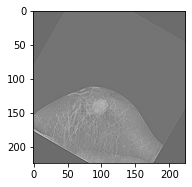

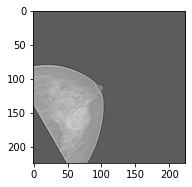

In [ ]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

In [ ]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="/content/mammography_images/train",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 573 validated image filenames belonging to 8 classes.


In [ ]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_accuracy',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min'),
               ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min',min_delta=1e-4)
]

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [ ]:
def build_model():
  model = Sequential()

  conv_base = DenseNet201(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(8, activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model

In [ ]:
my_model=build_model()

74842112/74836368 [==============================] - 1s 0us/step


In [ ]:
my_model.compile(optimizer =tf.keras.optimizers.Adam(learning_rate=0.00001,decay=0.0001),metrics=["accuracy"],loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1))

In [ ]:
my_model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=5,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/5
160/160 [==============================] - 90s 560ms/step - loss: 0.6533 - accuracy: 1.0000 - val_loss: 0.6591 - val_accuracy: 0.9926

Epoch 00001: val_accuracy did not improve from 0.99816
Epoch 2/5
160/160 [==============================] - 91s 570ms/step - loss: 0.6348 - accuracy: 1.0000 - val_loss: 0.6548 - val_accuracy: 0.9945

Epoch 00002: val_accuracy did not improve from 0.99816
Epoch 3/5
160/160 [==============================] - 92s 576ms/step - loss: 0.6301 - accuracy: 1.0000 - val_loss: 0.6548 - val_accuracy: 0.9945

Epoch 00003: val_accuracy did not improve from 0.99816
Epoch 4/5
160/160 [==============================] - 93s 581ms/step - loss: 0.6170 - accuracy: 1.0000 - val_loss: 0.6355 - val_accuracy: 0.9982

Epoch 00004: val_accuracy did not improve from 0.99816
Epoch 5/5
160/160 [==============================] - 93s 582ms/step - loss: 0.6073 - accuracy: 1.0000 - val_loss: 0.6192 - val_accuracy: 1.0000

Epoch 00005: val_accuracy improved from 0.99816 to 1.00

In [ ]:
m.evaluate(valid_generator,verbose=1)

18/18 [==============================] - 7s 136ms/step - loss: 0.6230 - accuracy: 1.0000


[0.6186696290969849, 1.0]

In [ ]:
my_model.load_weights(checkpoint_path)

In [ ]:
my_model.evaluate(valid_generator,verbose=1)

18/18 [==============================] - 3s 135ms/step - loss: 0.6187 - accuracy: 1.0000


[0.6186696290969849, 1.0]

In [ ]:
train_generator.class_indices

{'Density1Benign': 0,
 'Density1Malignant': 1,
 'Density2Benign': 2,
 'Density2Malignant': 3,
 'Density3Benign': 4,
 'Density3Malignant': 5,
 'Density4Benign': 6,
 'Density4Malignant': 7}

In [ ]:
test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/mammography_images/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 1908 validated image filenames.


In [ ]:
pred1=np.argmax(my_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1),axis=1)

1908/1908 [==============================] - 44s 23ms/step


In [ ]:
pred1

array([4, 0, 3, ..., 3, 3, 3])

In [ ]:
sub["label"]=pred1
sub["label"]=sub["label"].map({0:'Density1Benign',
 1:'Density1Malignant',
 2:'Density2Benign',
 3:'Density2Malignant',
 4: 'Density3Benign',
 5: 'Density3Malignant',
 6:'Density4Benign',
 7:  'Density4Malignant'})

In [ ]:
sub["label"].value_counts()

Density2Malignant    576
Density1Malignant    540
Density3Benign       234
Density1Benign       216
Density3Malignant    144
Density4Benign       108
Density2Benign        72
Density4Malignant     18
Name: label, dtype: int64

In [ ]:
sub.to_csv("9.csv",index=False)